#Importing all the necessary packages

In [1]:
import numpy as np
import cv2
import random
import os
import matplotlib.pyplot as plt
from imutils import paths
import face_recognition

from keras.models import Sequential
from keras.layers.core import Activation
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import applications
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import load_model
from keras import backend as K
from collections import defaultdict

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, precision_recall_fscore_support, average_precision_score, confusion_matrix
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/home/tennyson/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tennyson/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tennyson/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tennyson/.local/lib/python3.6/site-packages/tensorflo

#Initializing parameters

In [28]:
path='data'
data = []
labels = []
features = []
RANDOM_STATE = 42
IMAGE_DIM = 48
TEST_SPLIT = 0.20
BATCH_SIZE = 50
EPOCHS = 15
INIT_LR = 1e-3

#Reading images with different classes

In [30]:
class_dir_paths = sorted(os.listdir(path))
class_dict = {}
idx = 0

for class_dir_path in class_dir_paths:
    if (os.path.isdir(os.path.join(path, class_dir_path))):
        class_name = class_dir_path
        class_dict[class_name] = idx
        idx += 1

print("Class information : ", class_dict)

Class information :  {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6}


In [31]:
imagePaths = sorted(list(paths.list_images(path)))
random.seed(RANDOM_STATE)
random.shuffle(imagePaths)
print(paths)

<module 'imutils.paths' from '/usr/local/lib/python3.6/dist-packages/imutils/paths.py'>


In [32]:
# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    face_locations = face_recognition.face_locations(image)
    i = face_locations[0]
    a = min(i[0],i[2])
    b = max(i[0],i[2])
    c = min(i[1],i[3])
    d = max(i[1],i[3])
#     image = cv2.rectangle(image,(i[0],i[1]),(i[2],i[3]), color, thickness) 
    image = image[a:b,c:d]
    image = cv2.resize(image, (IMAGE_DIM, IMAGE_DIM))
    image = img_to_array(image)
    data.append(image)
    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(class_dict[label])

print("Total number of images readed, ", len(data))
print("Total number of labels extracted, ", len(labels))

Total number of images readed,  1913
Total number of labels extracted,  1913


#Preprocessing image

In [33]:
data = np.array(data, dtype="float")/255.0
labels = np.array(labels)
data.shape

(1913, 48, 48, 3)

#Splitting data into train and test

In [34]:

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=RANDOM_STATE)

print("Number of image in training set ", len(trainX), len(trainY))
print("Number of image in tesing set ", len(testX), len(testY))

Number of image in training set  1530 1530
Number of image in tesing set  383 383


In [35]:
trainY = to_categorical(trainY, num_classes=len(class_dict))
testY = to_categorical(testY, num_classes=len(class_dict))

#Deep Learning using Transfer Learning

In [84]:

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_DIM, IMAGE_DIM, 3))
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [85]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [86]:

# Building model based on Function API
X = base_model.output
X = Flatten()(X)  

#Adding last FC layers based on hyperparams given

X = Dense(64, activation='relu')(X)
# X = Dense(128, activation='relu')(X)

# for layer_param in hyperparameters['top_layers']:
# 	X = self.layers[layer_param[0]](layer_param[1], activation=layer_param[2])(X)

#Adding dropout
X = Dropout(0.5)(X)

#Adding the last layer for prediction
predictions = Dense(7, activation='softmax')(X)

#creating the final model
model = Model(base_model.input, predictions)


In [40]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(IMAGE_DIM, IMAGE_DIM,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(output_dim = 7, activation='softmax'))

/home/tennyson/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=7)`


In [89]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["categorical_accuracy"])

In [90]:
#fitting model with the data 
# model.fit(trainX, trainY, epochs=15, batch_size=10, validation_data=(testX, testY))

In [91]:
#data augmentation for further imrpovements but not used so far
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")
datagen.fit(trainX)

In [92]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
model.fit_generator(datagen.flow(trainX, trainY, batch_size=BATCH_SIZE),
                   epochs=EPOCHS, validation_data=(testX, testY),verbose=0, callbacks=[es])

Epoch 00011: early stopping


In [93]:
_, train_acc = model.evaluate(trainX, trainY, verbose=0)
_, test_acc = model.evaluate(testX, testY, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.640, Test: 0.671


#Model evaluation

In [94]:
# evaluate the model : train
scores = model.evaluate(trainX, trainY)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


# evaluate the model : test
scores = model.evaluate(testX, testY)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

1530/1530 [==============================] - 5s 3ms/step

categorical_accuracy: 63.99%
383/383 [==============================] - 1s 3ms/step

categorical_accuracy: 67.10%


In [95]:
model.save('keras_model') #save model 

In [96]:
model=load_model('keras_model') #load model without training model again


#Expression prediction

In [103]:
camera = cv2.VideoCapture(0)
input("Show some emotion and press enter to continue")
return_value, image = camera.read()
cv2.imwrite('opencv.jpg', image)
del(camera)

Show some emotion and press enter to continue


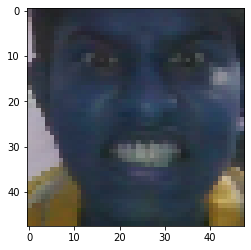

In [104]:
image = cv2.imread('opencv.jpg')
face_locations = face_recognition.face_locations(image)
i = face_locations[0]
a = min(i[0],i[2])
b = max(i[0],i[2])
c = min(i[1],i[3])
d = max(i[1],i[3])
#     image = cv2.rectangle(image,(i[0],i[1]),(i[2],i[3]), color, thickness) 
image = image[a:b,c:d]       
# pre-process the image for classification\n
image = cv2.resize(image, (IMAGE_DIM, IMAGE_DIM))
plt.imshow(image)
image = image.astype(float) / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
#         load the trained convolutional neural network

In [105]:
(anger,contempt,disgust,fear,happy,sadness,surprise) = model.predict(image)[0]
(anger,contempt,disgust,fear,happy,sadness,surprise)

(0.28064045,
 0.2104858,
 0.048251748,
 0.056567922,
 0.02441036,
 0.09274004,
 0.28690368)

In [106]:
x=dict(zip(('anger','contempt','disgust','fear','happy','sadness','surprise'),(anger,contempt,disgust,fear,happy,sadness,surprise)))
max_key = max(x, key=lambda k: x[k])
max_key

'surprise'

In [22]:
os.remove('opencv.jpg')